In [34]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

In [35]:
from kmeans import MyKMeans


def kmeans_exec(k, image_array):
    """Function to execute k-means clustering using custom implementation."""
    kmeanalgo = MyKMeans(k = k, random_state = 0)
    kmeanalgo.fit(image_array)
    centroids = kmeanalgo.centroids
    indices = kmeanalgo.predict(image_array)
    return centroids, indices

In [36]:
from sklearn.cluster import KMeans

def skkmeans_exec(k, image_array):
    """Function to execute k-means clustering using built-in implementation."""
    kmeanalgo = KMeans(n_clusters=k, random_state=0)
    kmeanalgo.fit(image_array)
    centroids = kmeanalgo.cluster_centers_
    indices = kmeanalgo.labels_
    return centroids, indices

In [37]:
def weight(index):
    """Calculate the weight of each pixel in the image."""
    _, counts = np.unique(index, return_counts=True)
    # return the relative frequency of each unique value in the index array
    return counts / len(index)  

In [38]:
def calc_prob(image, c1, i1, c2, i2):
    """Calculate the probability of each pixel in the image belonging to foreground or background."""
    # Get the clusters' weights
    cluster1_weight = weight(i1)
    cluster2_weight = weight(i2)

    # Reshape the image array to 2D for broadcasting (n, 3)
    reshaped_img = image.reshape(-1, 3)

    # Calculate foreground probabilities
    cluster1_distances = np.linalg.norm(reshaped_img[:, np.newaxis] - c1, axis=2)
    cluster1_probs = np.sum(cluster1_weight * np.exp(-cluster1_distances), axis=1)

    # Calculate background probabilities
    cluster2_distances = np.linalg.norm(reshaped_img[:, np.newaxis] - c2, axis=2)
    cluster2_probs = np.sum(cluster2_weight * np.exp(-cluster2_distances), axis=1)

    # Assign pixels to foreground or background based on higher probability
    binary_weights = np.where(cluster1_probs > cluster2_probs, 255, 0)

    # Reshape the result back to the original image shape before returning 
    return binary_weights.reshape(image.shape[:2])

In [39]:
def mydisplay(bw, image, seed_image_array ):
    """Segment the image using the binary weights and display the results."""
    # Create a 3D mask from the 2D bw array
    mask = np.stack([bw]*3, axis=-1)

    # Create the segmented images by applying the mask
    cluster1_image_array = np.where(mask, image, 0)
    cluster2_image_array = np.where(mask, 0, image)

    # Convert the images to RGB
    dst0 = cv2.cvtColor(seed_image_array, cv2.COLOR_BGR2RGB)
    dst1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dst2 = cv2.cvtColor(cluster1_image_array, cv2.COLOR_BGR2RGB)
    dst3 = cv2.cvtColor(cluster2_image_array, cv2.COLOR_BGR2RGB)

    # Create a figure with 4 subplots
    fig, axs = plt.subplots(1, 4, figsize = (16, 4))

    # Display each image on a separate subplot
    for ax, dst in zip(axs, [dst0, dst1, dst2, dst3]):
        ax.axis('off')
        ax.imshow(dst)

    plt.show()


In [40]:
def lazySnapping(image_array, seed_image_array, seed_k, k):
    """The main function to perform all steps of lazy snapping.""" 
    start_time = time.time()
    
    # Step 1) Reshape seed image array and perform k-means clustering on it  
    _, seed_indices = kmeans_exec(seed_k, seed_image_array.reshape(-1, 3))
    
    #reshape the image back to original shape without the third dimension
    seed_indices = seed_indices.reshape(image_array.shape[:2])
    
    # Filter out the most frequent value (black pixels) in the seed image array
    unique, counts = np.unique(seed_indices, return_counts=True)
    unique = np.delete(unique, np.argmax(counts))
    
    # Step 2) extract the foreground and background pixels from the image array
    cluster1_pixels = image_array[seed_indices == unique[0]]
    cluster2_pixels = image_array[seed_indices == unique[1]]
    
    # Step 3) Perform k-means clustering on both seed clusters separately
    cluster1_centroids, cluster1_indices = kmeans_exec(k, cluster1_pixels) 
    cluster2_centroids, cluster2_indices = kmeans_exec(k, cluster2_pixels)
    
    # Step 4) Calculate the probability of each pixel in the image belonging to either cluster (foreground or background)
    bin_weight_mask = calc_prob(image_array, cluster1_centroids, cluster1_indices, cluster2_centroids, cluster2_indices)
    
    # Step 4) Display the results
    mydisplay(bin_weight_mask, image_array, seed_image_array)
    
    end_time = time.time()
    
    print('Process time:')
    print(f'{end_time - start_time:.4f}s ({(end_time - start_time) / 60:.3f} minutes)')

    

In [41]:
def lazySnapping2(image_array, seed_image_array, seed_k, k):
    """The main function to perform all steps of lazy snapping.""" 
    start_time = time.time()
    
    # Step 1) Reshape seed image array and perform k-means clustering on it  
    _, seed_indices = skkmeans_exec(seed_k, seed_image_array.reshape(-1, 3))
    
    #reshape the image back to original shape without the third dimension
    seed_indices = seed_indices.reshape(image_array.shape[:2])
    
    # Filter out the most frequent value (black pixels) in the seed image array
    unique, counts = np.unique(seed_indices, return_counts=True) 
    unique = np.delete(unique, np.argmax(counts))
    
    # Step 2) extract the foreground and background pixels from the image array
    cluster1_pixels = image_array[seed_indices == unique[0]]
    cluster2_pixels = image_array[seed_indices == unique[1]]
    
    # Step 3) Perform k-means clustering on both seed clusters separately
    cluster1_centroids, cluster1_indices = skkmeans_exec(k, cluster1_pixels) 
    cluster2_centroids, cluster2_indices = skkmeans_exec(k, cluster2_pixels)
    
    # Step 4) Calculate the probability of each pixel in the image belonging to either cluster (foreground or background)
    bin_weight_mask = calc_prob(image_array, cluster1_centroids, cluster1_indices, cluster2_centroids, cluster2_indices)
    
    # Step 4) Display the results
    mydisplay(bin_weight_mask, image_array, seed_image_array)
    
    end_time = time.time()
    
    print('Process time:')
    print(f'{end_time - start_time:.4f}s ({(end_time - start_time) / 60:.3f} minutes)')

In [42]:
# Test image 1
lady_seed_1 = cv2.imread('data/lady stroke 1.png')
lady_seed_2 = cv2.imread('data/lady stroke 2.png')
lady = cv2.imread('data/lady.PNG')

# Test image 2
mona_seed_1 = cv2.imread('data/Mona-lisa stroke 1.png')
mona_seed_2 = cv2.imread('data/Mona-lisa stroke 2.png')
mona = cv2.imread('data/Mona-lisa.PNG')

# Test image 3
van_seed = cv2.imread('data/van Gogh stroke.png')
van = cv2.imread('data/van Gogh.PNG')

In [43]:
images = [(lady, lady_seed_1), (lady, lady_seed_2), (mona, mona_seed_1), (mona, mona_seed_2), (van, van_seed)]
N_values = [2, 32, 64, 98, 128]

Using custom implementation of k-means clustering:
Result with 2 clusters: 


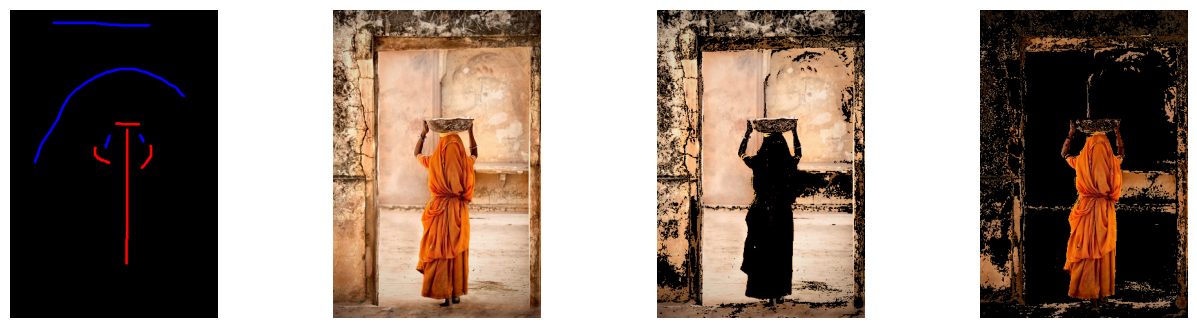

Process time:
0.4567s (0.008 minutes)
Result with 32 clusters: 


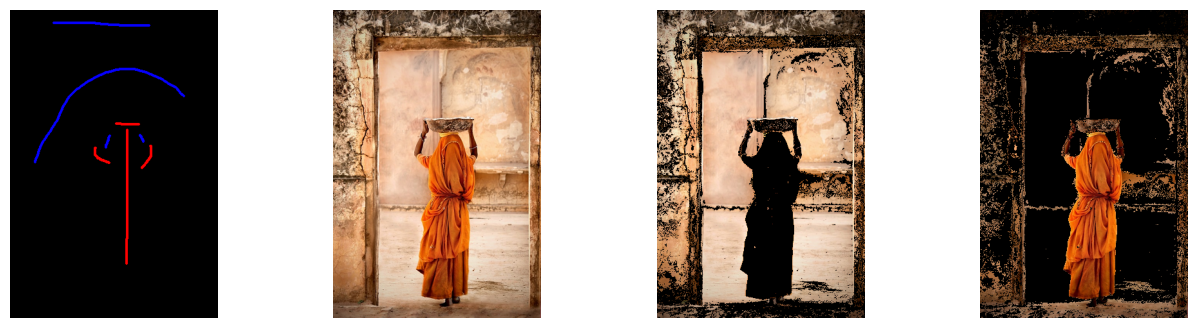

Process time:
1.0481s (0.017 minutes)
Result with 64 clusters: 


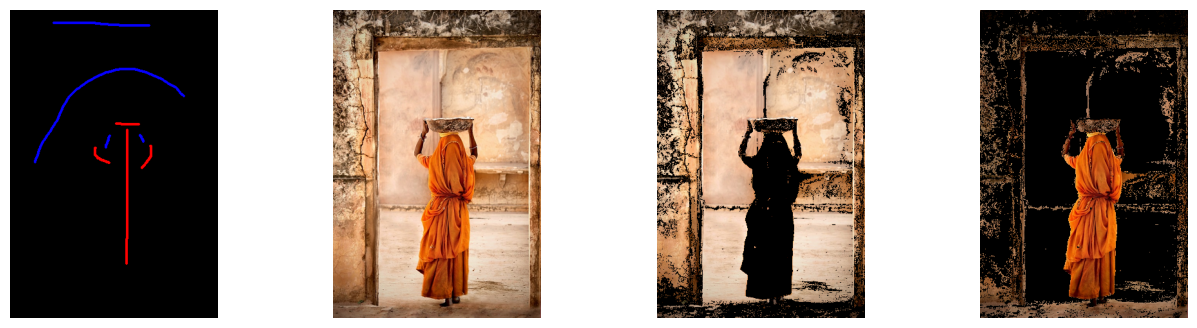

Process time:
1.8127s (0.030 minutes)
Result with 98 clusters: 


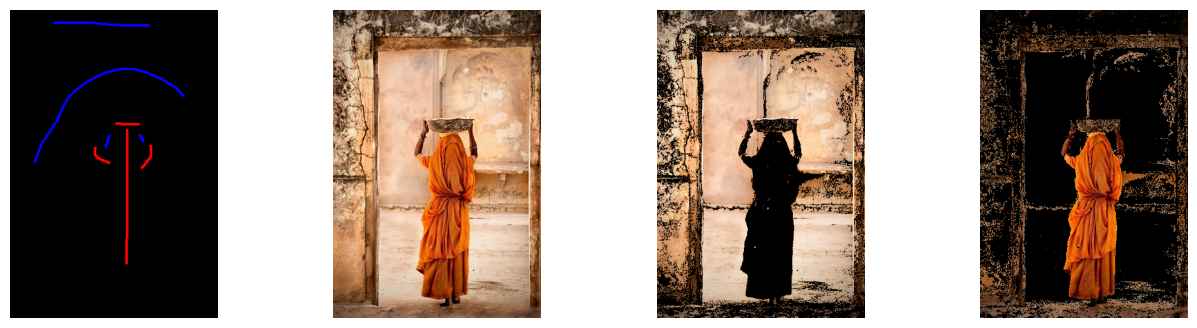

Process time:
2.4993s (0.042 minutes)
Result with 128 clusters: 


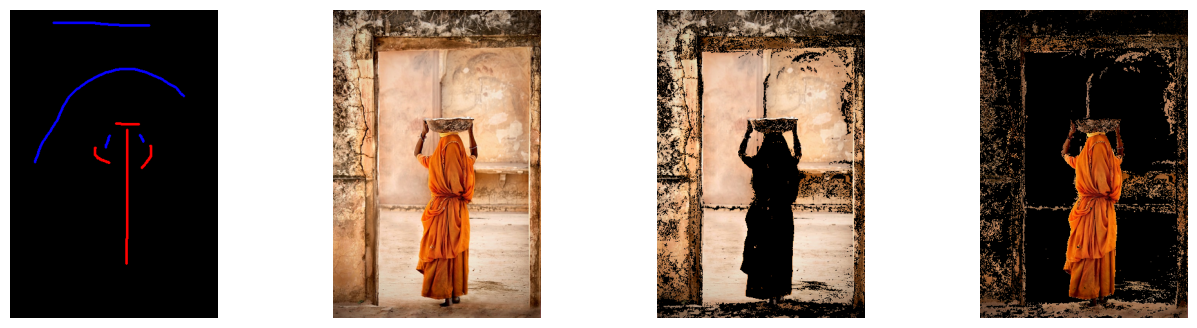

Process time:
3.4333s (0.057 minutes)
Result with 2 clusters: 


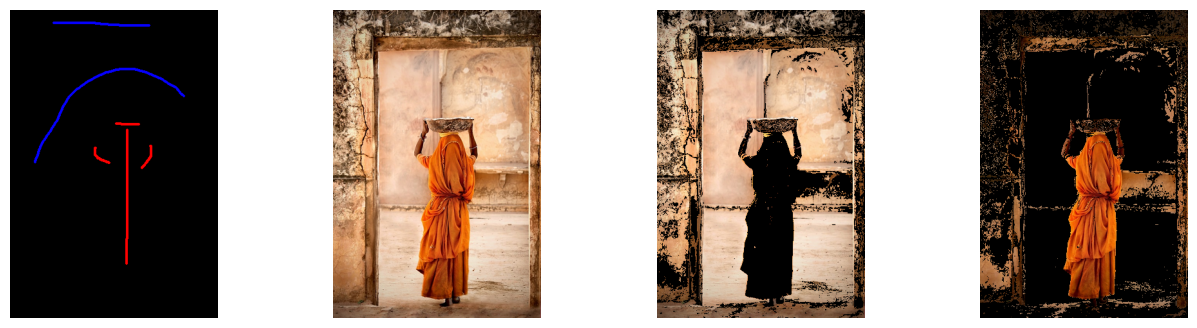

Process time:
0.4184s (0.007 minutes)
Result with 32 clusters: 


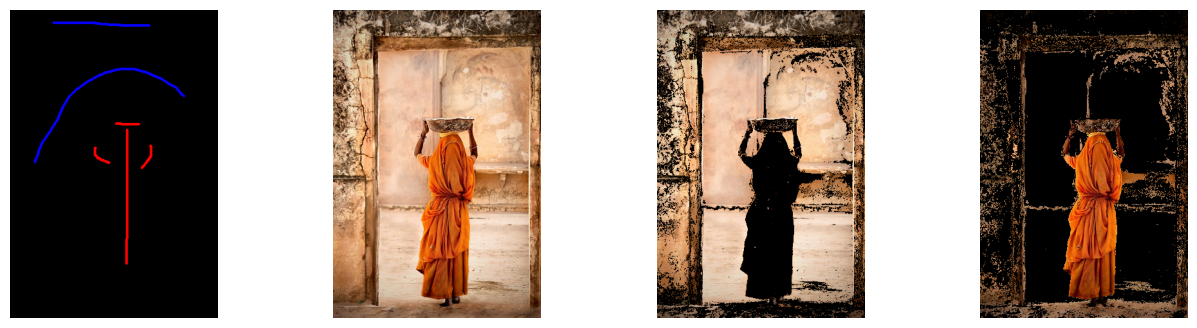

Process time:
0.9903s (0.017 minutes)
Result with 64 clusters: 


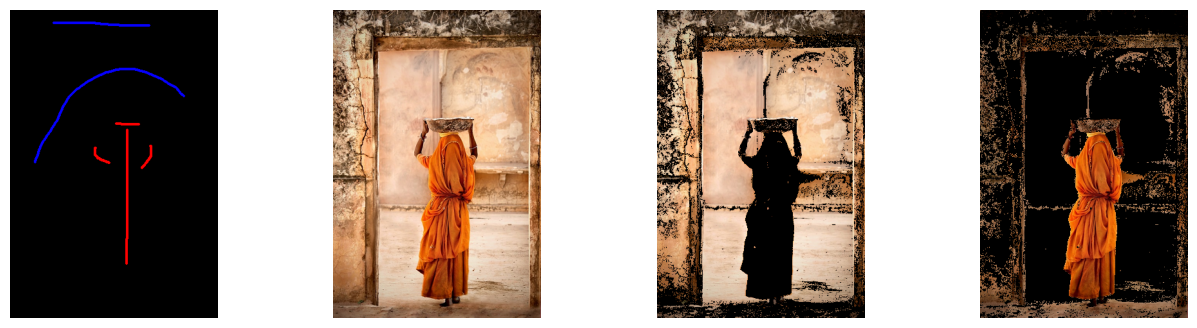

Process time:
1.8067s (0.030 minutes)
Result with 98 clusters: 


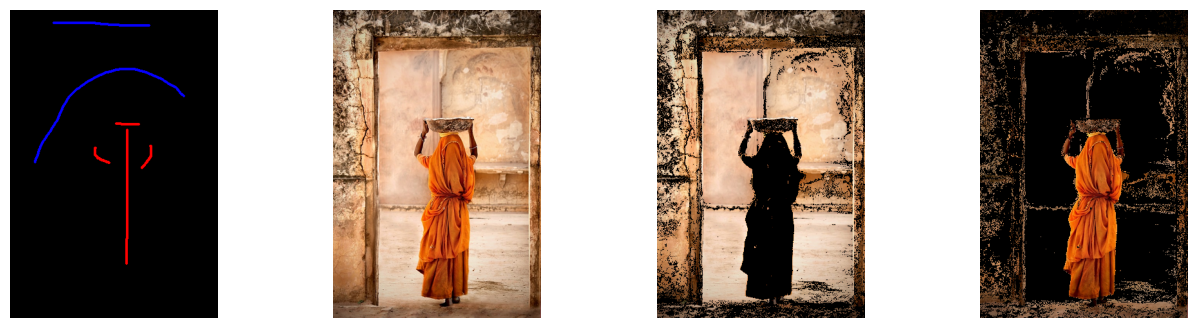

Process time:
2.4634s (0.041 minutes)
Result with 128 clusters: 


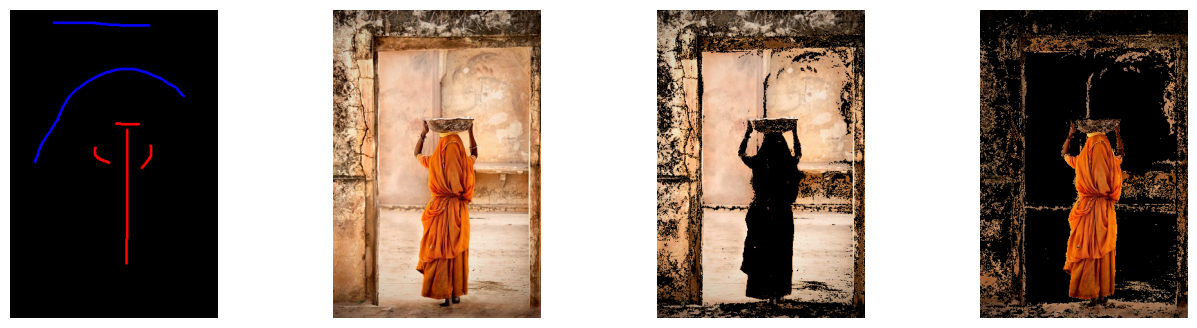

Process time:
3.3724s (0.056 minutes)
Result with 2 clusters: 


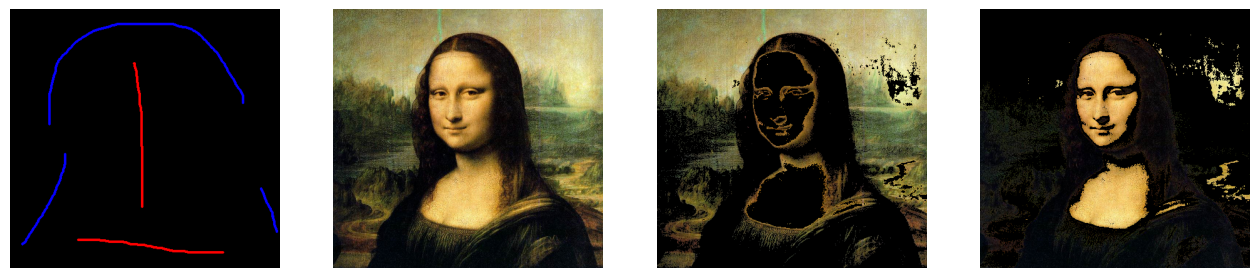

Process time:
0.4012s (0.007 minutes)
Result with 32 clusters: 


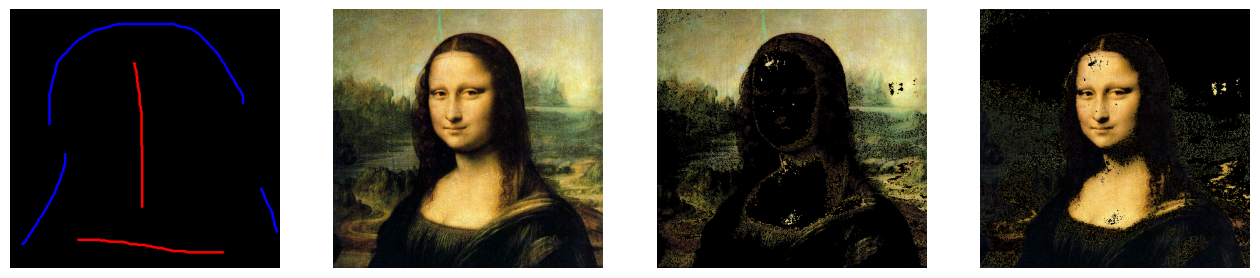

Process time:
1.2335s (0.021 minutes)
Result with 64 clusters: 


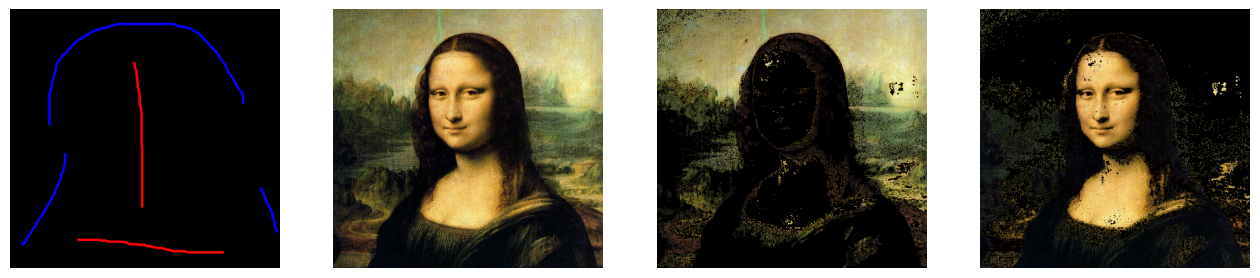

Process time:
2.3940s (0.040 minutes)
Result with 98 clusters: 


KeyboardInterrupt: 

In [44]:
print('Using custom implementation of k-means clustering:')
for image, seed in images:
    for N in N_values:
        print('----------------------------------------')
        print(f'Result with {N} clusters: ')
        lazySnapping(image, seed, 3, N)

In [ ]:
print('Using built-in implementation of k-means clustering:')
for image, seed in images:
    for N in N_values:
        print('----------------------------------------')
        print(f'Result with {N} clusters: ')
        lazySnapping2(image, seed, 3, N)